<a href="https://colab.research.google.com/github/f1shstyxx/DS_capstone/blob/main/Project_3_LLM/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - (Insert Title)

## Business Understanding

### Background

### Dataset Details

### Project Goals

### Project Considerations

## Data Understanding

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# set random seed for reproducibility
def set_seed(seed_value=42):
  random.seed(seed_value)
  np.random.seed(seed_value)
  os.environ['PYTHONHASHSEED'] = str(seed_value)

set_seed()

In [3]:
# install hugging face
!pip install datasets

In [4]:
# load samsum dataset
from datasets import load_dataset

dataset = load_dataset('knkarthick/samsum')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})


In [6]:
print(dataset['train'][0])

{'id': '13818513', 'dialogue': "Amanda: I baked  cookies. Do you want some?\nJerry: Sure!\nAmanda: I'll bring you tomorrow :-)", 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}


In [7]:
# convert train, validation and test datasets to dataframes

df_train = pd.DataFrame(dataset['train'])
print(df_train.head())

df_val = pd.DataFrame(dataset['validation'])
print(df_val.head())

df_test = pd.DataFrame(dataset['test'])
print(df_test.head())

         id                                           dialogue  \
0  13818513  Amanda: I baked  cookies. Do you want some?\nJ...   
1  13728867  Olivia: Who are you voting for in this electio...   
2  13681000  Tim: Hi, what's up?\nKim: Bad mood tbh, I was ...   
3  13730747  Edward: Rachel, I think I'm in ove with Bella....   
4  13728094  Sam: hey  overheard rick say something\nSam: i...   

                                             summary  
0  Amanda baked cookies and will bring Jerry some...  
1  Olivia and Olivier are voting for liberals in ...  
2  Kim may try the pomodoro technique recommended...  
3  Edward thinks he is in love with Bella. Rachel...  
4  Sam is confused, because he overheard Rick com...  
         id                                           dialogue  \
0  13817023  A: Hi Tom, are you busy tomorrow’s afternoon?\...   
1  13716628  Emma: I’ve just fallen in love with this adven...   
2  13829420  Jackie: Madison is pregnant\nJackie: but she d...   
3  138196

### Text Exploration

In [17]:
# train df basic info and describe
print(df_train.info())
print(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14732 entries, 0 to 14731
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           14732 non-null  object
 1   dialogue     14731 non-null  object
 2   summary      14732 non-null  object
 3   text_length  14732 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 460.5+ KB
None
        text_length
count  14732.000000
mean      93.786451
std       74.033371
min        1.000000
25%       39.000000
50%       73.000000
75%      128.000000
max      803.000000


In [18]:
# length of train df
print(f"Length of train df: {len(df_train)}")

Length of train df: 14732


In [27]:
# text length analysis
# analysis will include speaker names
df_train['text_length'] = df_train['dialogue'].apply(lambda x: len(str(x).split()))
print(f"\nAverage text length: {df_train['text_length'].mean():.2f} words")
print(f"\nMedian text length: {df_train['text_length'].median():.2f} words")
print(f"\nMinimum text length: {df_train['text_length'].min()} words")
print(f"\nMaximum text length: {df_train['text_length'].max()} words")


Average text length: 93.79 words

Median text length: 73.00 words

Minimum text length: 7 words

Maximum text length: 803 words


In [19]:
# check for missing values
print(df_train.isnull().sum())

id             0
dialogue       1
summary        0
text_length    0
dtype: int64


In [22]:
# drop row from df_train with missing value in dialogue column
df_train = df_train.dropna(subset=['dialogue'])
print(df_train.isnull().sum())
print(f"\nLength of train df: {len(df_train)}")

id             0
dialogue       0
summary        0
text_length    0
dtype: int64

Length of train df: 14731


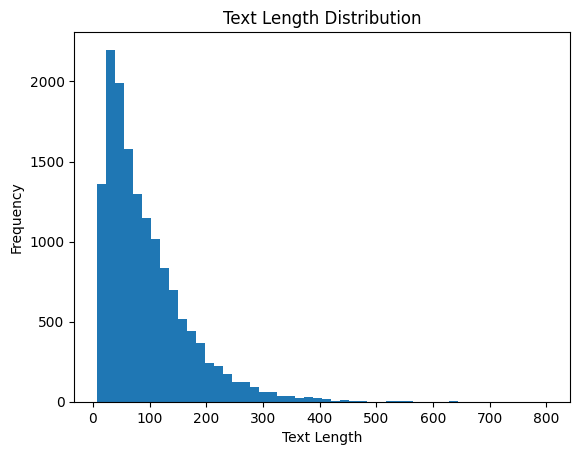

In [24]:
plt.hist(df_train['text_length'], bins=50)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [28]:
# examples of dialogue and summary
print(f"\nDialogue: {df_train['dialogue'][5]}")
print(f"\nSummary: {df_train['summary'][5]}")

print(f"\nDialogue: {df_train['dialogue'][1000]}")
print(f"\nSummary: {df_train['summary'][1000]}")


Dialogue: Neville: Hi there, does anyone remember what date I got married on?
Don: Are you serious?
Neville: Dead serious. We're on vacation, and Tina's mad at me about something. I have a strange suspicion that this might have something to do with our wedding anniversary, but I have nowhere to check.
Wyatt: Hang on, I'll ask my wife.
Don: Haha, someone's in a lot of trouble :D
Wyatt: September 17. I hope you remember the year ;)

Summary: Wyatt reminds Neville his wedding anniversary is on the 17th of September. Neville's wife is upset and it might be because Neville forgot about their anniversary.

Dialogue: Ann: Do you have plans for the holidays this year?
Mary: Well we thought of going for a hike somewhere beautiful
Mary: and you?
Ann: We talked about it last night and we thought maybe you would like to do sth together?
Mary: Why not
Mary: just remember that we're outdoorsy people :D
Ann: I know, but you're not even considering a nice beach somewhere?
Mary: weeeeell, that's not r

## Data Preparation

## Modeling

## Evaluation

# Conclusion